# Statistical Algos

## Notebook's Environment

In [ ]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

## Cloud Environment Setup

In [ ]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

# Instruments

In [ ]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

## Data Load

In [ ]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

In [ ]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]

# Support and Resistance with Clustering

https://www.researchgate.net/publication/255993239_The_Bollinger_lines_and_pivot_points_-_methods_of_making_the_best_decision_in_the_stock_exchange

In [ ]:
from quant_equations import *

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")
HALF_LIFE, HURST

In [73]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import multiprocessing
NUM_CORES = multiprocessing.cpu_count()

def find_optimal_clusters(data, max_clusters=150, min_clusters=2, max_no_improvement=5, sample_size=1000):
    def evaluate_clusters(n_clusters, data):
        km = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=(256 * NUM_CORES), max_no_improvement=max_no_improvement)
        labels = km.fit_predict(data)
        if len(np.unique(labels)) < 2:
            return -1
        score = silhouette_score(data, labels, sample_size=sample_size)
        return score

    best_score = -1
    best_k = None
    low = min_clusters
    high = max_clusters

    while low <= high:
        mid = (low + high) // 2
        score = evaluate_clusters(mid, data)
        low_score = evaluate_clusters(mid - 1, data) if mid - 1 >= low else -1
        high_score = evaluate_clusters(mid + 1, data) if mid + 1 <= high else -1
        if score > best_score:
            best_score = score
            best_k = mid
        if low_score > score:
            high = mid - 1
        elif high_score > score:
            low = mid + 1
        else:
            break  # local maximum

    return best_k

def sr_clusters_dtw(df, cols, max_clusters=150):
    data = df[cols].values
    optimal_clusters = find_optimal_clusters(data, max_clusters=max_clusters)
    km_model = MiniBatchKMeans(n_clusters=optimal_clusters, batch_size=(256 * NUM_CORES))
    labels = km_model.fit_predict(data)

    cluster_df = pd.DataFrame(data, columns=cols)
    cluster_df['cluster'] = labels

    return cluster_df, km_model

def identify_support_resistance(cluster_df, km_model, target_col):
    centers = km_model.cluster_centers_
    cluster_means = cluster_df[['cluster', target_col]].groupby('cluster').mean()

    support_level = cluster_means.mean(axis=1).idxmin()
    support_value = centers[support_level].mean()
    resistance_level = cluster_means.mean(axis=1).idxmax()
    resistance_value = centers[resistance_level].mean()

    return support_value, resistance_value

def dynamic_support_resistance(df, cols, window_size=20, max_clusters=20):
    assert window_size >= max_clusters

    dynamic_support = []
    dynamic_resistance = []
    for start in tqdm(np.arange(0, window_size + 1, window_size)):
        window_df = df.iloc[start:start + window_size]
        cluster_df, km_model = sr_clusters_dtw(window_df, cols, max_clusters=window_size - 1)
        support, resistance = identify_support_resistance(cluster_df, km_model, f"{TARGET_FUT}_Close")

        dynamic_support.append(support)
        dynamic_resistance.append(resistance)

    return dynamic_support, dynamic_resistance

TARGET_FUT = 'ZW'
cols = [f"{TARGET_FUT}_High", f"{TARGET_FUT}_Low", f"{TARGET_FUT}_Open", f"{TARGET_FUT}_Close",
        f"{TARGET_FUT}_PP", f"{TARGET_FUT}_S1", f"{TARGET_FUT}_S2", f"{TARGET_FUT}_R1", f"{TARGET_FUT}_R2"]

futs_df[f"{TARGET_FUT}_PP"] = futs_df[[f"{TARGET_FUT}_High", f"{TARGET_FUT}_Low", f"{TARGET_FUT}_Close"]].mean(axis=1)
futs_df[f"{TARGET_FUT}_S1"] = 2 * futs_df[f"{TARGET_FUT}_PP"] - futs_df[f"{TARGET_FUT}_High"]
futs_df[f"{TARGET_FUT}_R1"] = 2 * futs_df[f"{TARGET_FUT}_PP"] - futs_df[f"{TARGET_FUT}_Low"]
futs_df[f"{TARGET_FUT}_S2"] = futs_df[f"{TARGET_FUT}_PP"] - (futs_df[f"{TARGET_FUT}_High"] - futs_df[f"{TARGET_FUT}_Low"])
futs_df[f"{TARGET_FUT}_R2"] = futs_df[f"{TARGET_FUT}_PP"] + (futs_df[f"{TARGET_FUT}_High"] - futs_df[f"{TARGET_FUT}_Low"])

WINDOW = len(futs_df) // 2
dynamic_support, dynamic_resistance = dynamic_support_resistance(futs_df, cols, window_size=WINDOW)
print(dynamic_support)
print(dynamic_resistance)

 50%|█████     | 1/2 [00:11<00:11, 11.58s/it]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"]}]



100%|██████████| 2/2 [00:29<00:00, 14.73s/it]


[539.0747302420529, 558.3583453583451]
[585.3055555555555, 694.8888888888889]


## Visual Results

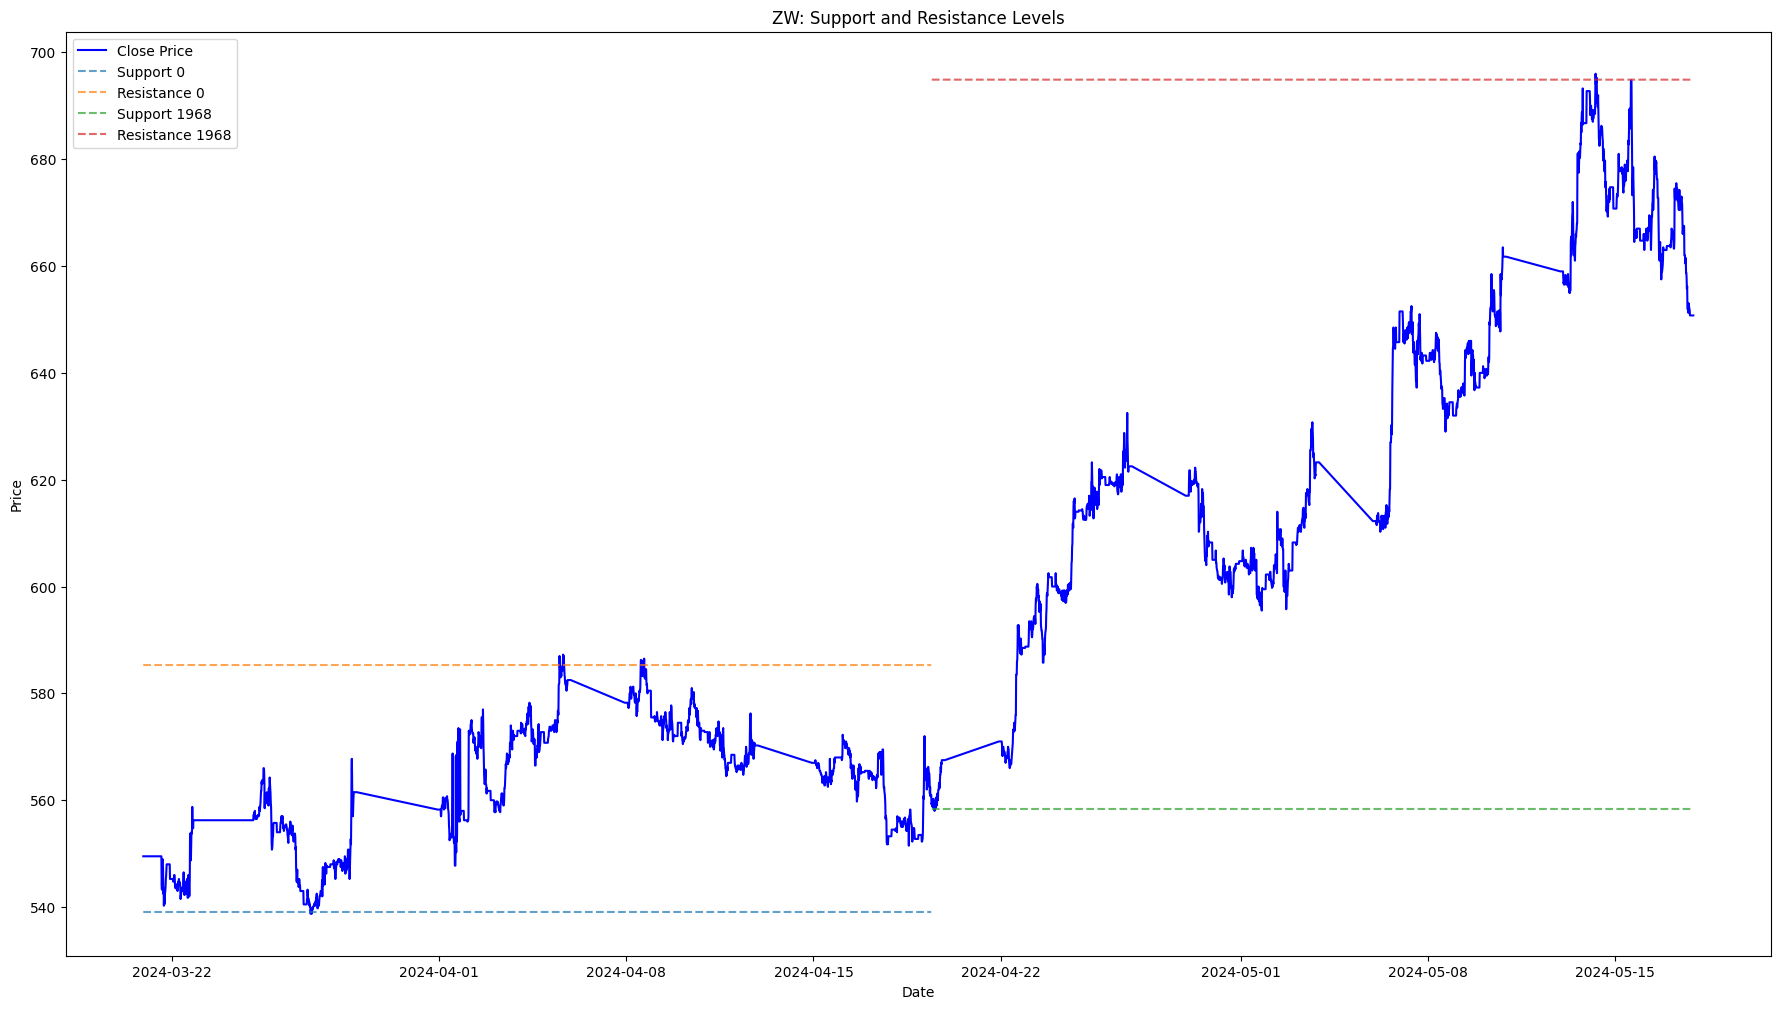

In [74]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(22, 12))
plt.plot(futs_df.index, futs_df[f"{TARGET_FUT}_Close"], label='Close Price', color='blue')
for i, sample in enumerate(np.arange(0, WINDOW + 1, WINDOW)):
    plt.plot(futs_df.index[sample:sample+WINDOW-1], [dynamic_support[i]] * (WINDOW-1), label=f'Support {sample}', linestyle='dashed', alpha=0.7)
    plt.plot(futs_df.index[sample:sample+WINDOW-1], [dynamic_resistance[i]] * (WINDOW-1), label=f'Resistance {sample}', linestyle='dashed', alpha=0.7)

plt.title(f"{TARGET_FUT}: Support and Resistance Levels")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()